In [122]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm

In [123]:
training_df = pd.read_csv(os.path.join('datalake/datasets', 'train_region_FWST.csv'))
training_df.head(3)

,Month-Year,Part Number,Region,Units sold per Part
0,2014-04-01,DS1010,FWST,2.0
1,2014-05-01,DS1010,FWST,1.0
2,2014-06-01,DS1010,FWST,3.0


In [124]:
df = training_df[training_df['Part Number']=='DS1017T']
df.head(3)

,Month-Year,Part Number,Region,Units sold per Part
100,2014-04-01,DS1017T,FWST,14.0
101,2014-05-01,DS1017T,FWST,16.0
102,2014-06-01,DS1017T,FWST,15.0


In [125]:
len_train = len(df['Units sold per Part'])-12

train = df[:len_train]
test = df[len_train:]

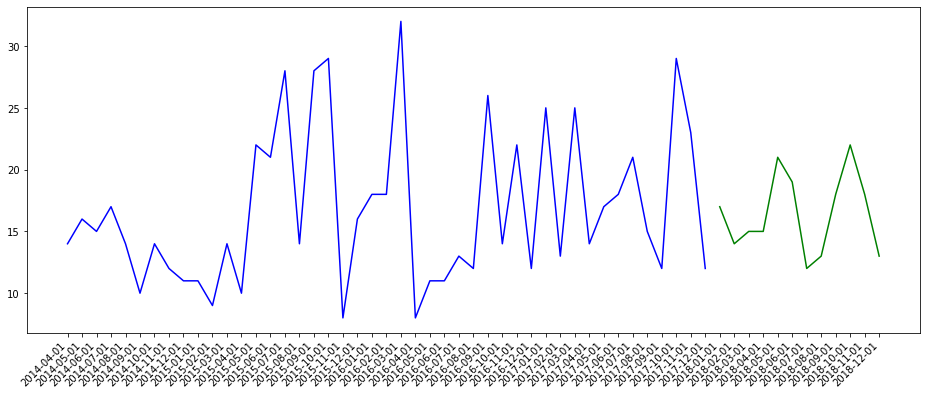

In [126]:
plt.figure(figsize=(16,6))
plt.xticks(rotation=45, ha="right")
plt.plot(train['Month-Year'], train['Units sold per Part'],color='blue')
plt.plot(test['Month-Year'], test['Units sold per Part'],color='green')

In [127]:
model = pm.auto_arima(train['Units sold per Part'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=322.345, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=307.190, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=320.346, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=305.183, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=304.360, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=302.405, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=303.210, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=300.218, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=298.268, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=297.085, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=295.138, Time=0.07 se

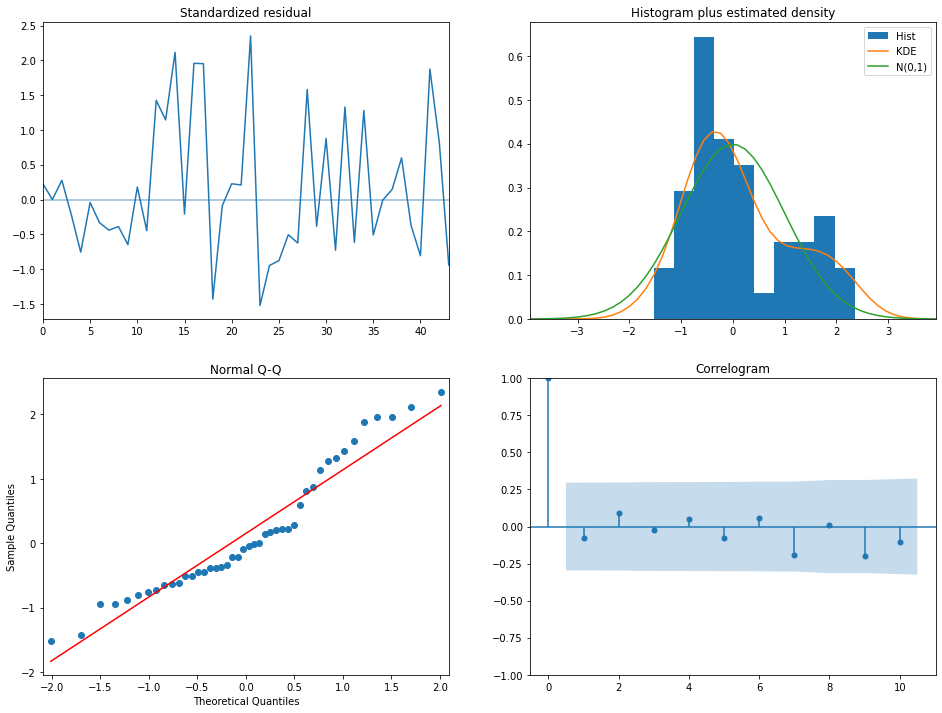

In [ ]:
model.plot_diagnostics(figsize=(16,12))
plt.show()

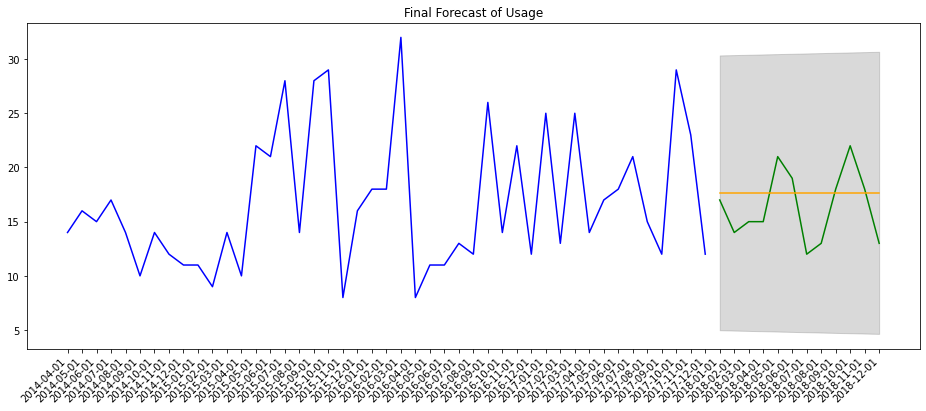

In [ ]:
# Forecast
n_periods = 12
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(train['Units sold per Part']), len(train['Units sold per Part'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16,6))
plt.xticks(rotation=45, ha="right")
plt.plot(train['Month-Year'],train['Units sold per Part'],color='blue')
plt.plot(test['Month-Year'],test['Units sold per Part'],color='green')
plt.plot(fc_series, color='orange')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

In [ ]:
# Accuracy metrics
def compute_accuracy(forecast, actual):
    print("forecast:", forecast)
    print("actual:", actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

accuracy = compute_accuracy(fc, np.array(test['Units sold per Part']))
print("accuracy:", accuracy)

forecast: [17.65933061 17.65933061 17.65933061 17.65933061 17.65933061 17.65933061
 17.65933061 17.65933061 17.65933061 17.65933061 17.65933061 17.65933061]
actual: [17. 14. 15. 15. 21. 19. 12. 13. 18. 22. 18. 13.]
accuracy: {'mape': 0.19233080454888662, 'me': 1.2426639448960988, 'mae': 2.8598884352604608, 'mpe': 0.11486474625921668, 'rmse': 3.3596531421413567, 'corr': 3.793947910950215e-16, 'minmax': 0.15489123667820381}
